# Laboratorio 06 - GANs

Integrantes:
- José Pablo Kiesling Lange, 21581
- Melissa Pérez Alarcón, 21385

### Librerías

In [1]:
import pandas as pd
import os
from PIL import Image
import torchvision.transforms as transforms
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

### Preparación de los datos

In [2]:
# Directorio de imágenes
image_dir = './data/img_align_celeba/img_align_celeba'

# transformaciones para redimensionar y normalizar las imágenes
transform = transforms.Compose([
    transforms.CenterCrop(128),                                          # Recorte central
    transforms.Resize((128, 128)),                                       # Redimensionar a 128x128
    transforms.ToTensor(),                                               # Convertir a tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])      # Normalizar
])

**IAGen prompt:** Using a large dataset of images as "[CelebFaces Attributes (CelebA) Dataset](https://www.kaggle.com/datasets/jessicali9530/celeba-dataset/)" for training a GAN. Which is the best way to load the data?

In [3]:
# Crear una función para cargar imágenes por lotes
def load_images_in_batches(image_dir, batch_size=64):
    # Obtener los nombres de los archivos de imágenes
    image_files = os.listdir(image_dir)
    
    # Definir un generador que cargue las imágenes por lotes
    for i in range(0, len(image_files), batch_size):
        batch_files = image_files[i:i+batch_size]
        images = []
        for file in batch_files:
            img_path = os.path.join(image_dir, file)
            image = Image.open(img_path)
            image = transform(image)
            images.append(image)
        yield torch.stack(images)  # lote de imágenes como un tensor

# Definir el tamaño de lote
batch_size = 64

# Obtener el generador de lotes
image_batch_gen = load_images_in_batches(image_dir, batch_size=batch_size)

# Mostrar el tamaño del primer lote
first_batch = next(image_batch_gen)

print(f"Tamaño del primer lote: {first_batch.shape}")

Tamaño del primer lote: torch.Size([64, 3, 128, 128])


**IAGen prompt:** How can I verify that the preprocessing is done correctly?

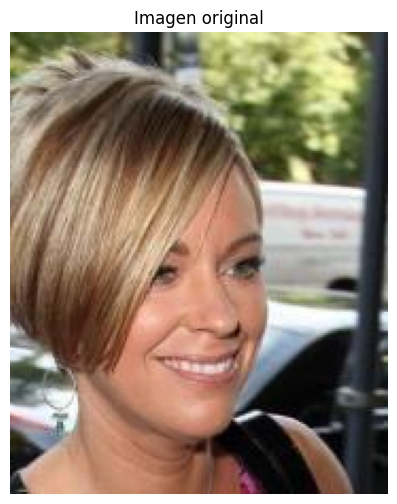

In [4]:
# Cargar una sola imagen para preprocesarla
image_files = os.listdir(image_dir)
image_path = os.path.join(image_dir, image_files[0])
image = Image.open(image_path)

# Mostrar la imagen original
plt.figure(figsize=(6,6))
plt.imshow(image)
plt.title("Imagen original")
plt.axis('off')
plt.show()

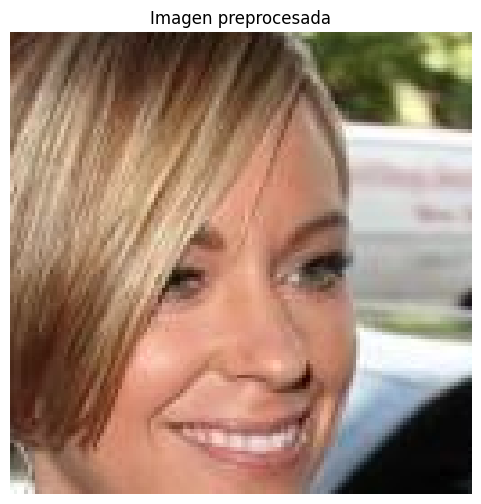

In [5]:
# Aplicar las transformaciones
image_transformed = transform(image)

# volver a los valores originales para visualización
def denormalize(tensor):
    tensor = tensor * torch.tensor([0.5, 0.5, 0.5]).view(3, 1, 1) + torch.tensor([0.5, 0.5, 0.5]).view(3, 1, 1)
    return torch.clamp(tensor, 0, 1)

# Desnormalizar la imagen para poder mostrarla
image_denorm = denormalize(image_transformed)

# Convertir el tensor a un formato numpy
image_np = image_denorm.permute(1, 2, 0).numpy()

# Mostrar la imagen preprocesada
plt.figure(figsize=(6,6))
plt.imshow(image_np)
plt.title("Imagen preprocesada")
plt.axis('off')
plt.show()

### Implementación de la GAN

**IAGen prompt:** Give me an example of layers to develop a generator of a GAN for output images on 128x128.

#### Generador

In [6]:
latent_dim = 100

generator = nn.Sequential(
    # Capa 1: Vector de ruido -> salida será 1024 canales de 4x4
    nn.ConvTranspose2d(latent_dim, 1024, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(1024),
    nn.ReLU(True),

    # Capa 2: 1024 canales de 4x4 -> salida será 512 canales de 8x8
    nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),

    # Capa 3: 512 canales de 8x8 -> salida será 256 canales de 16x16
    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),

    # Capa 4: 256 canales de 16x16 -> salida será 128 canales de 32x32
    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),

    # Capa 5: 128 canales de 32x32 -> salida será 64 canales de 64x64
    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),

    # Capa 6: 64 canales de 64x64 -> salida será 3 canales de 128x128 (RGB)
    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()  # Usamos Tanh para que los valores estén entre [-1, 1]
)

# Crear un tensor de ruido aleatorio
noise = torch.randn(1, latent_dim, 1, 1)

# Generar una imagen falsa a partir del ruido
fake_image = generator(noise)

# Verificar las dimensiones de la imagen generada
print(f"Dimensiones de la imagen generada: {fake_image.shape}")

Dimensiones de la imagen generada: torch.Size([1, 3, 128, 128])


**IAGen prompt:** Now, based on the implemented generator, develop the discriminator.
#### Discriminador

In [7]:
discriminator = nn.Sequential(
    # Capa 1: 3 canales de entrada (imagen RGB) -> salida 64 canales
    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.LeakyReLU(0.2, inplace=True),

    # Capa 2: 64 canales de 64x64 -> salida 128 canales de 32x32
    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),

    # Capa 3: 128 canales de 32x32 -> salida 256 canales de 16x16
    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),

    # Capa 4: 256 canales de 16x16 -> salida 512 canales de 8x8
    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),

    # Capa 5: 512 canales de 8x8 -> salida 1 valor de probabilidad
    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    nn.Sigmoid()
)

# tensor de tamaño (1, 3, 128, 128) para representar una imagen RGB
fake_image = torch.randn(1, 3, 128, 128)

# Pasar la imagen por el discriminador
output = discriminator(fake_image)

# Verificar la salida del discriminador
print(f"Salida del discriminador: {output}")
print(f"Dimensiones de la salida del discriminador: {output.shape}")

Salida del discriminador: tensor([[[[0.6528, 0.5583, 0.5868, 0.4629, 0.5749],
          [0.5054, 0.5053, 0.5382, 0.5567, 0.6478],
          [0.6398, 0.5997, 0.5455, 0.5417, 0.4277],
          [0.5576, 0.3997, 0.5188, 0.5304, 0.4424],
          [0.7378, 0.7331, 0.5453, 0.5496, 0.6234]]]],
       grad_fn=<SigmoidBackward0>)
Dimensiones de la salida del discriminador: torch.Size([1, 1, 5, 5])


**IAGen prompt:** Having already implemented the generator and discriminator, it's time to define the loss functions and optimizers to train the GAN. Please develop an example of them.
#### Funciones de pérdida y optimizadores

In [8]:
# Definir la función de pérdida (Binary Cross Entropy)
criterion = nn.BCELoss()

# Parámetros del optimizador
lr = 0.0002  # Tasa de aprendizaje
beta1 = 0.5  # Parámetro beta1 para el optimizador Adam

# Definir los optimizadores para el generador y el discriminador
optimizerG = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerD = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))

# Crear etiquetas reales y falsas para la función de pérdida
real_label = 1.
fake_label = 0.

# Supongamos que el tamaño de lote es 64
batch_size = 64

# Crear un tensor de etiquetas reales
real_labels = torch.full((batch_size,), real_label, dtype=torch.float)
# Crear un tensor de etiquetas falsas
fake_labels = torch.full((batch_size,), fake_label, dtype=torch.float)

### Entrenamiento de la GAN

### Reflexión

1. ¿Qué conceptos de la teoría encontraron más desafiantes y por qué?
2. ¿Cómo les ayudó el laboratorio a consolidar o entender mejor estos conceptos?
3. ¿Qué aplicaciones potenciales ven para las GANs en la industria o en la investigación?
4. ¿Qué limitaciones o preocupaciones éticas pueden identificar en el uso de GANs?
5. ¿Cómo se sienten con respecto a la implementación y entrenamiento de GANs después de la experiencia práctica?